# Libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import mediapipe as mp
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.svm import SVC
from xgboost import XGBClassifier
from scipy.spatial import ConvexHull
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
)

# Constants

In [2]:
CACHE_DIR = "./cache"
DATASET_DIR = "./dataset" 

DATASET_FILE = f"{CACHE_DIR}/dataset.csv"

LANDMARKS_PAIRS = [
    # Tip-to-tip (neighboring fingers)
    (4, 8), (8, 12), (12, 16), (16, 20),

    # Wrist to each fingertip
    (0, 4), (0, 8), (0, 12), (0, 16), (0, 20),

    # Tip to base of the same finger (to capture bending)
    (4, 3), (8, 6), (12, 10), (16, 14), (20, 18),

    # Thumb to other fingertips (e.g., letters like G, L)
    (4, 12), (4, 16), (4, 20),

    # Palm width: base-to-base
    (5, 17), (2, 20)
]
LANDMARKS_TRIPLETS = [
    # Index finger
    (5, 6, 7), (6, 7, 8),

    # Middle finger
    (9, 10, 11), (10, 11, 12),

    # Ring finger
    (13, 14, 15), (14, 15, 16),

    # Pinky finger
    (17, 18, 19), (18, 19, 20),

    # Thumb
    (1, 2, 3), (2, 3, 4),

    # Palm structure
    (0, 5, 9), (0, 9, 13), (0, 13, 17)
]
LANDMARKS_TIPS = [4, 8, 12, 16, 20]
LANDMARKS_PIPS = [3, 6, 10, 14, 18]

os.makedirs(CACHE_DIR, exist_ok=True)

# Initialize mediapipe

In [3]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1)
mp_draw = mp.solutions.drawing_utils

# Get the coordinates and extract the features

In [4]:
def normalize_landmarks(points):
  center = points[0]
  points = points - center

  scale = np.linalg.norm(points[0] - points[9])
  if scale != 0:
    points = points / scale
  
  return points

def pairwise_distances(landmarks, pairs):
  dists = []
  for i, j in pairs:
    dists.append(np.linalg.norm(landmarks[i] - landmarks[j]))
  return np.array(dists)

def angles(landmarks, triples):
  angs = []
  for i, j, k in triples:
    v1 = landmarks[i] - landmarks[j]
    v2 = landmarks[k] - landmarks[j]
    # cosθ = (v1·v2) / (‖v1‖‖v2‖)
    cosang = np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2) + 1e-8)
    θ = np.degrees(np.arccos(np.clip(cosang, -1, 1)))
    angs.append(θ)
  return np.array(angs)

def convex_hull_area(landmarks):
  hull = ConvexHull(landmarks)
  return hull.area

def count_extended_fingers(landmarks, finger_tips, finger_pips):
  wrist = landmarks[0]
  count = 0
  for tip, pip in zip(finger_tips, finger_pips):
    d_tip = np.linalg.norm(landmarks[tip] - wrist)
    d_pip = np.linalg.norm(landmarks[pip] - wrist)
    if d_tip > d_pip:
      count += 1
  return count

def bounding_box_features(landmarks):
  x = [pt[0] for pt in landmarks]
  y = [pt[1] for pt in landmarks]
  width = max(x) - min(x)
  height = max(y) - min(y)
  aspect_ratio = width / (height + 1e-6)
  return width, height, aspect_ratio

def hand_orientation_angle(landmarks):
  wrist = np.array(landmarks[0])
  middle_base = np.array(landmarks[9])
  vec = middle_base - wrist
  angle = np.arctan2(vec[1], vec[0])
  return angle

def create_dataset():
  data = []

  for label in tqdm(os.listdir(DATASET_DIR), desc="Reading and extracting", unit="label"):
    label_path = os.path.join(DATASET_DIR, label)
    for image in os.listdir(label_path):
      image_path = os.path.join(label_path, image)

      img = cv2.imread(image_path)
      img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      results = hands.process(img_rgb)

      if not results.multi_hand_landmarks:
        print(f"Warning: No hand landmarks found in {image_path}. Skipping...")
        continue

      for hand in results.multi_hand_landmarks:
        h, w, _ = img.shape
        points = []
        for lm in hand.landmark:
          x = lm.x * w
          y = lm.y * h
          points.append([x, y])
        
        points = np.array(points)

        points = normalize_landmarks(points)

        dist_feats = pairwise_distances(points, LANDMARKS_PAIRS)
        ang_feats = angles(points, LANDMARKS_TRIPLETS)
        area = convex_hull_area(points)
        angle = hand_orientation_angle(points)
        n_extended = count_extended_fingers(points, LANDMARKS_TIPS, LANDMARKS_PIPS)
        width, height, aspect_ratio = bounding_box_features(points)

        sample = { "label": label }

        for i, val in enumerate(dist_feats):
          sample[f"dist_{i}"] = val
        
        for i, val in enumerate(ang_feats):
          sample[f"ang_{i}"] = val

        sample["area"] = area
        sample["angle"] = angle
        sample["width"] = width
        sample["height"] = height
        sample["aspect_ratio"] = aspect_ratio
        sample["n_extended"] = n_extended

        data.append(sample)

  df = pd.DataFrame(data)
  df.to_csv(DATASET_FILE, index=False)
    
if not os.path.exists(DATASET_FILE):
  print("Not found dataset file, creating...")
  create_dataset()
else:
  print("Dataset file found, loading...")

Dataset file found, loading...


# Try to predict with models


🔍 Evaluando: Logistic Regression


c:\Users\Jorge Mora\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


📊 Accuracy: 0.9105
              precision    recall  f1-score   support

           0       0.50      0.78      0.61         9
           1       0.92      1.00      0.96        12
           2       0.93      0.87      0.90        15
           3       1.00      0.94      0.97        17
           4       0.79      1.00      0.88        11
           5       0.79      0.92      0.85        12
           6       0.81      0.77      0.79        22
           7       1.00      1.00      1.00        13
           8       1.00      1.00      1.00        16
           9       1.00      1.00      1.00        14
           a       1.00      1.00      1.00        13
           b       1.00      1.00      1.00        16
           c       1.00      1.00      1.00        12
           d       0.91      1.00      0.95        10
           e       1.00      0.86      0.92        14
           f       1.00      1.00      1.00        18
           g       0.92      0.86      0.89        14
        

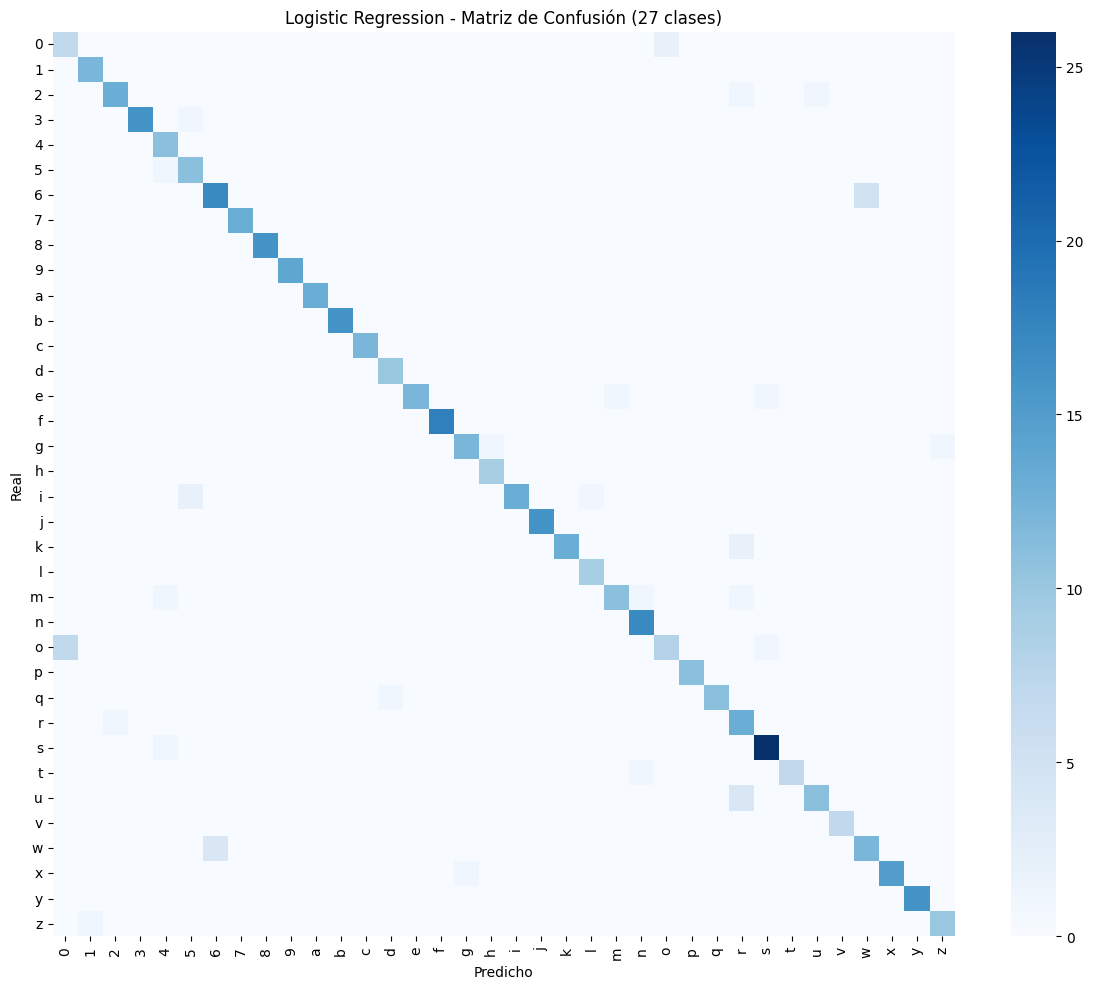

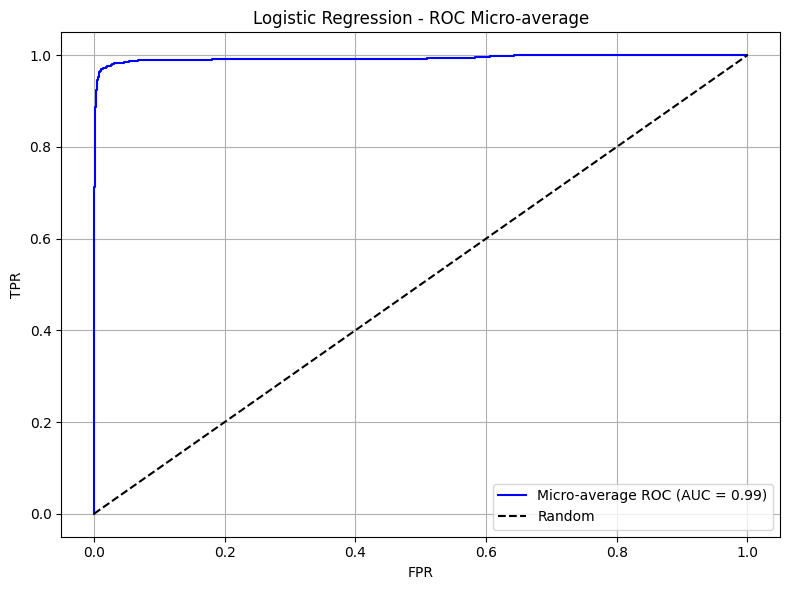


🔍 Evaluando: Random Forest
📊 Accuracy: 0.9543
              precision    recall  f1-score   support

           0       0.54      0.78      0.64         9
           1       0.92      1.00      0.96        12
           2       1.00      0.80      0.89        15
           3       1.00      1.00      1.00        17
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00        12
           6       0.91      0.91      0.91        22
           7       1.00      1.00      1.00        13
           8       1.00      1.00      1.00        16
           9       1.00      1.00      1.00        14
           a       1.00      1.00      1.00        13
           b       1.00      1.00      1.00        16
           c       1.00      1.00      1.00        12
           d       1.00      1.00      1.00        10
           e       1.00      1.00      1.00        14
           f       1.00      1.00      1.00        18
           g       1.00      0.93 

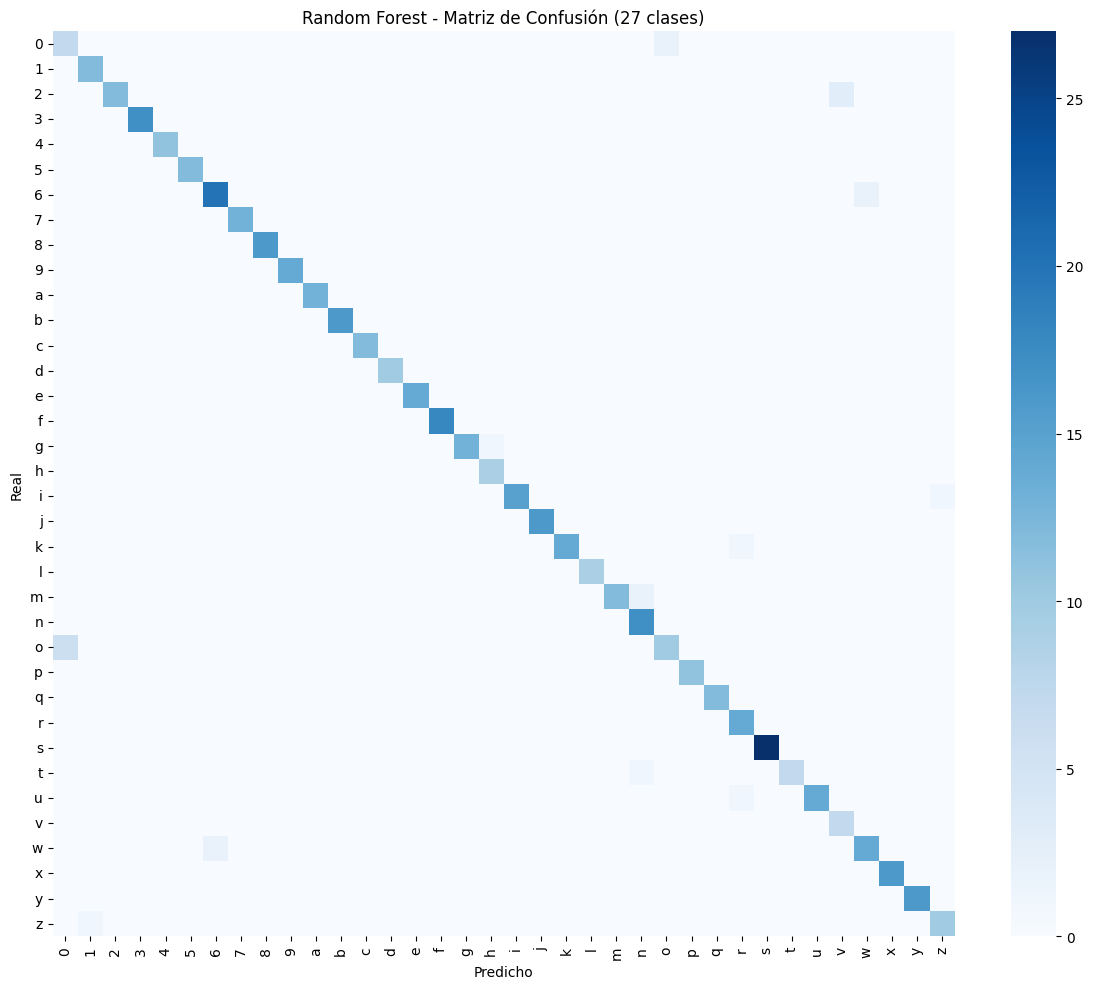

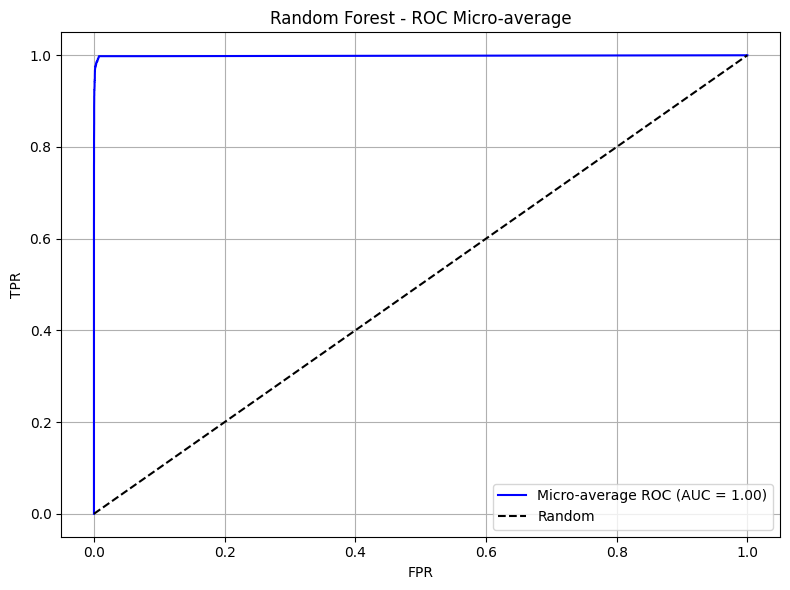


🔍 Evaluando: SVM
📊 Accuracy: 0.5408
              precision    recall  f1-score   support

           0       0.29      0.78      0.42         9
           1       0.20      0.08      0.12        12
           2       0.00      0.00      0.00        15
           3       1.00      0.24      0.38        17
           4       0.39      1.00      0.56        11
           5       0.86      1.00      0.92        12
           6       0.00      0.00      0.00        22
           7       1.00      1.00      1.00        13
           8       0.89      1.00      0.94        16
           9       0.44      1.00      0.61        14
           a       0.54      1.00      0.70        13
           b       0.00      0.00      0.00        16
           c       0.69      0.92      0.79        12
           d       0.71      1.00      0.83        10
           e       0.45      1.00      0.62        14
           f       0.00      0.00      0.00        18
           g       1.00      0.14      0.25 

c:\Users\Jorge Mora\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jorge Mora\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jorge Mora\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

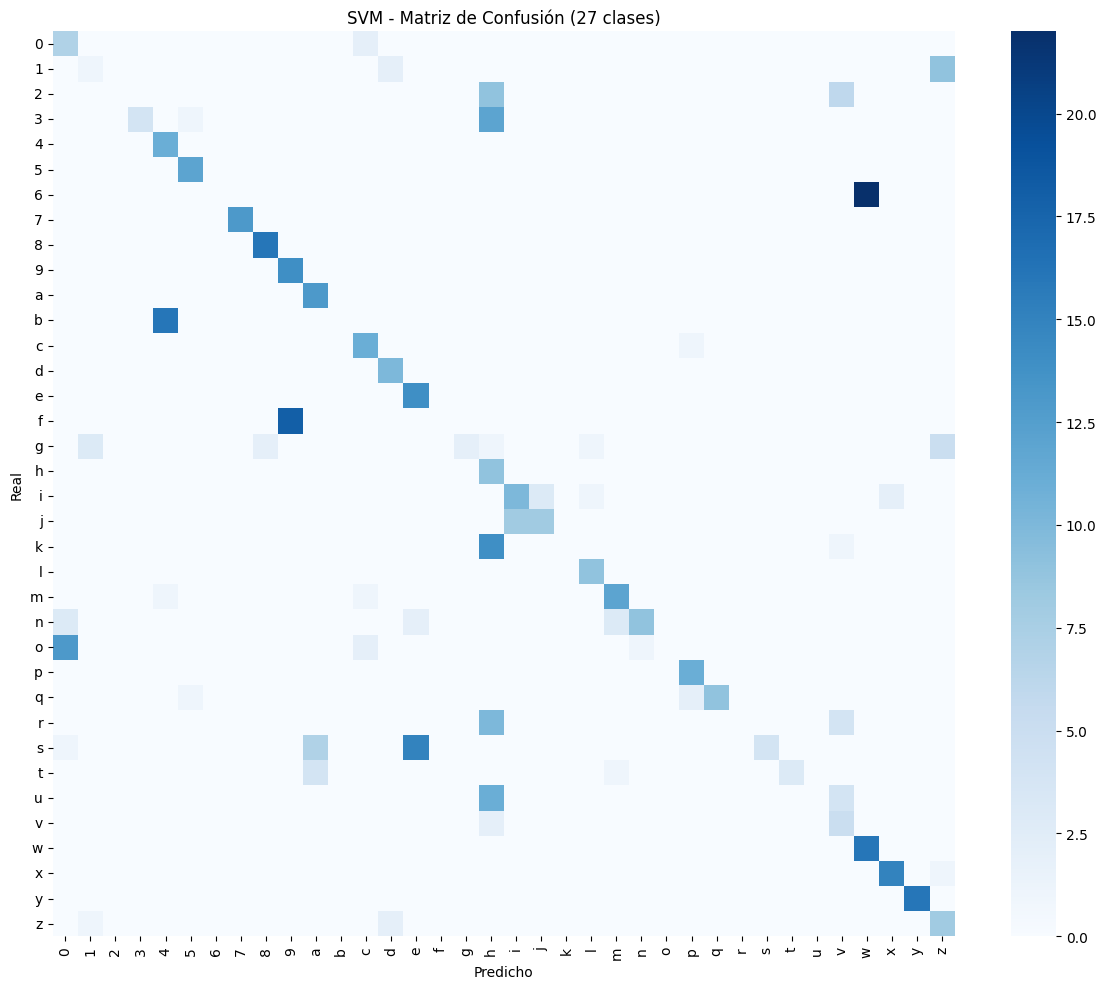

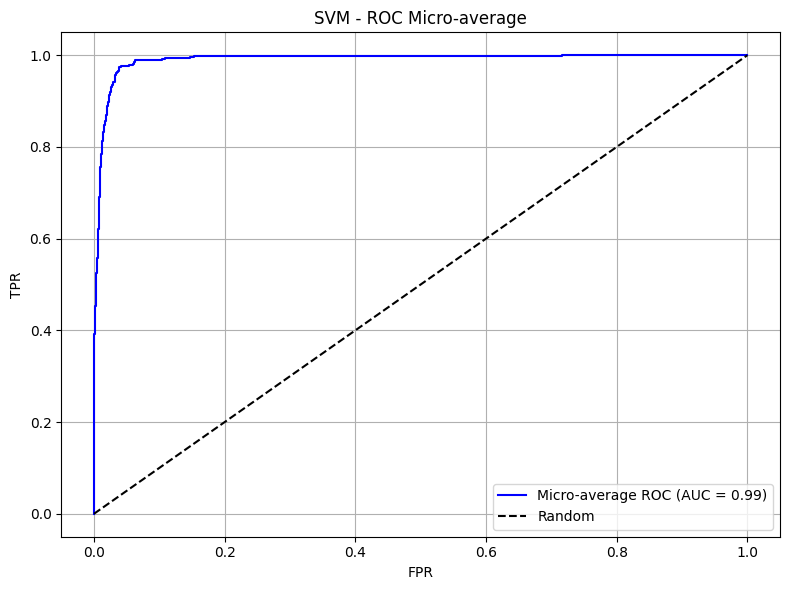


🔍 Evaluando: KNN
📊 Accuracy: 0.8111
              precision    recall  f1-score   support

           0       0.37      0.78      0.50         9
           1       0.73      0.92      0.81        12
           2       0.53      0.67      0.59        15
           3       1.00      0.88      0.94        17
           4       0.85      1.00      0.92        11
           5       0.92      1.00      0.96        12
           6       0.82      0.82      0.82        22
           7       1.00      1.00      1.00        13
           8       1.00      1.00      1.00        16
           9       0.61      1.00      0.76        14
           a       0.87      1.00      0.93        13
           b       0.93      0.88      0.90        16
           c       1.00      0.92      0.96        12
           d       0.91      1.00      0.95        10
           e       0.93      1.00      0.97        14
           f       1.00      0.50      0.67        18
           g       0.92      0.86      0.89 

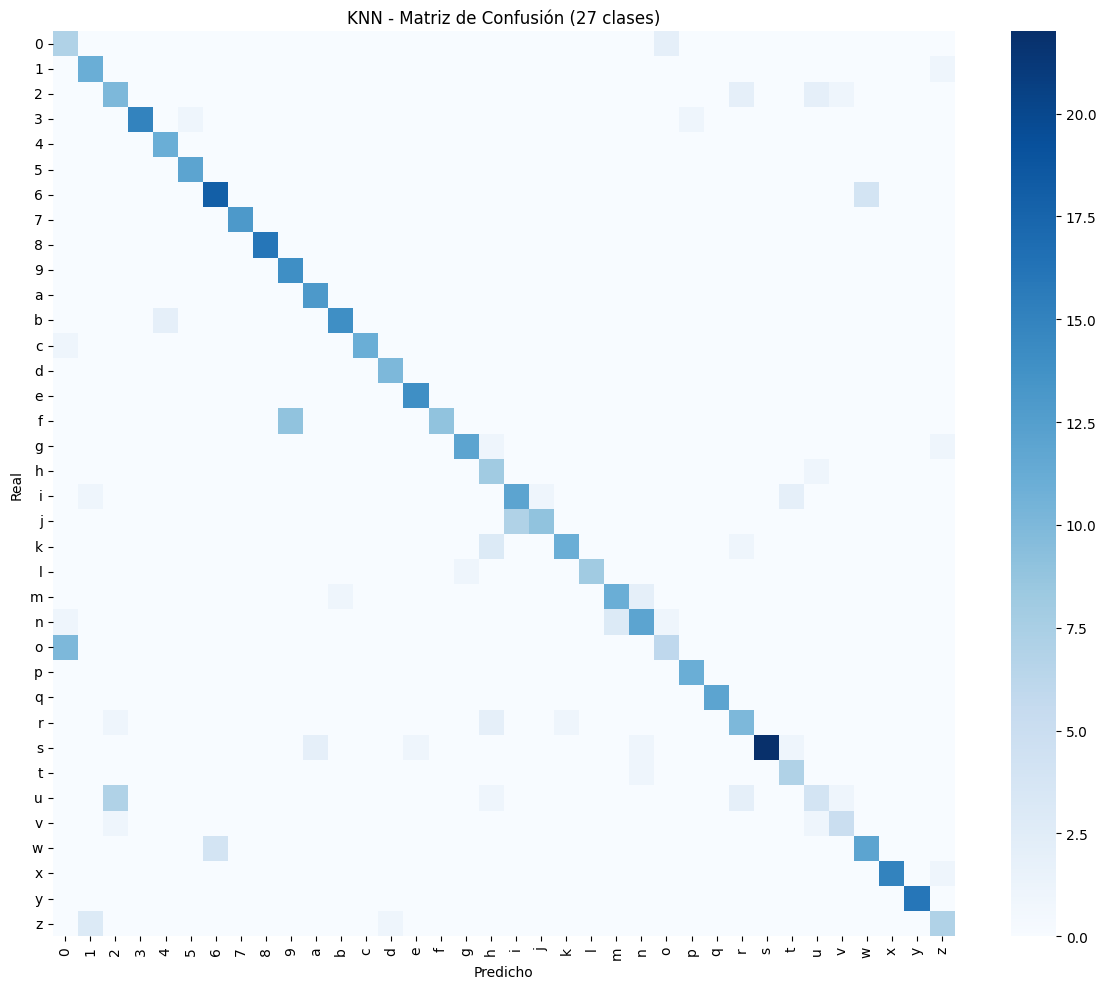

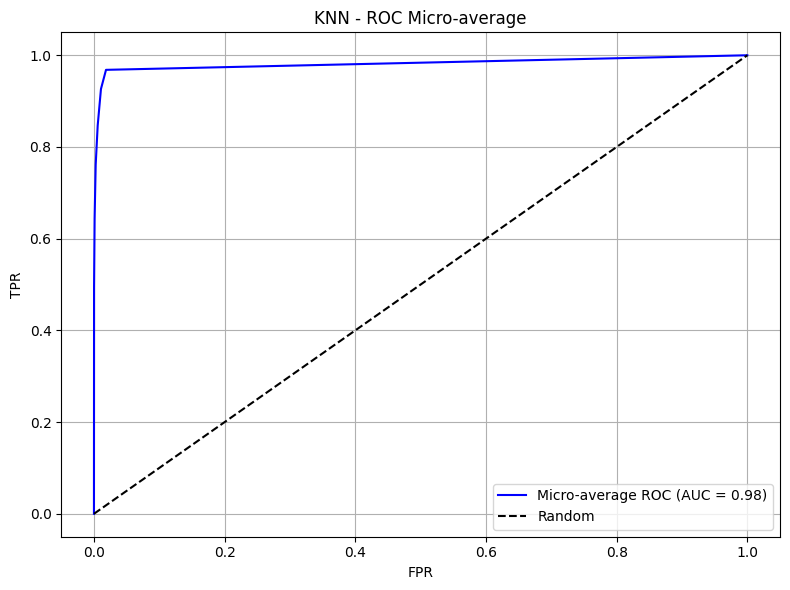


🔍 Evaluando: XGBoost


c:\Users\Jorge Mora\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [23:56:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 Accuracy: 0.9205
              precision    recall  f1-score   support

           0       0.47      0.78      0.58         9
           1       1.00      0.67      0.80        12
           2       1.00      0.87      0.93        15
           3       1.00      1.00      1.00        17
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00        12
           6       0.83      0.86      0.84        22
           7       1.00      1.00      1.00        13
           8       1.00      1.00      1.00        16
           9       0.93      1.00      0.97        14
           a       1.00      1.00      1.00        13
           b       1.00      1.00      1.00        16
           c       1.00      0.92      0.96        12
           d       0.90      0.90      0.90        10
           e       1.00      0.93      0.96        14
           f       1.00      0.94      0.97        18
           g       1.00      0.93      0.96        14
        

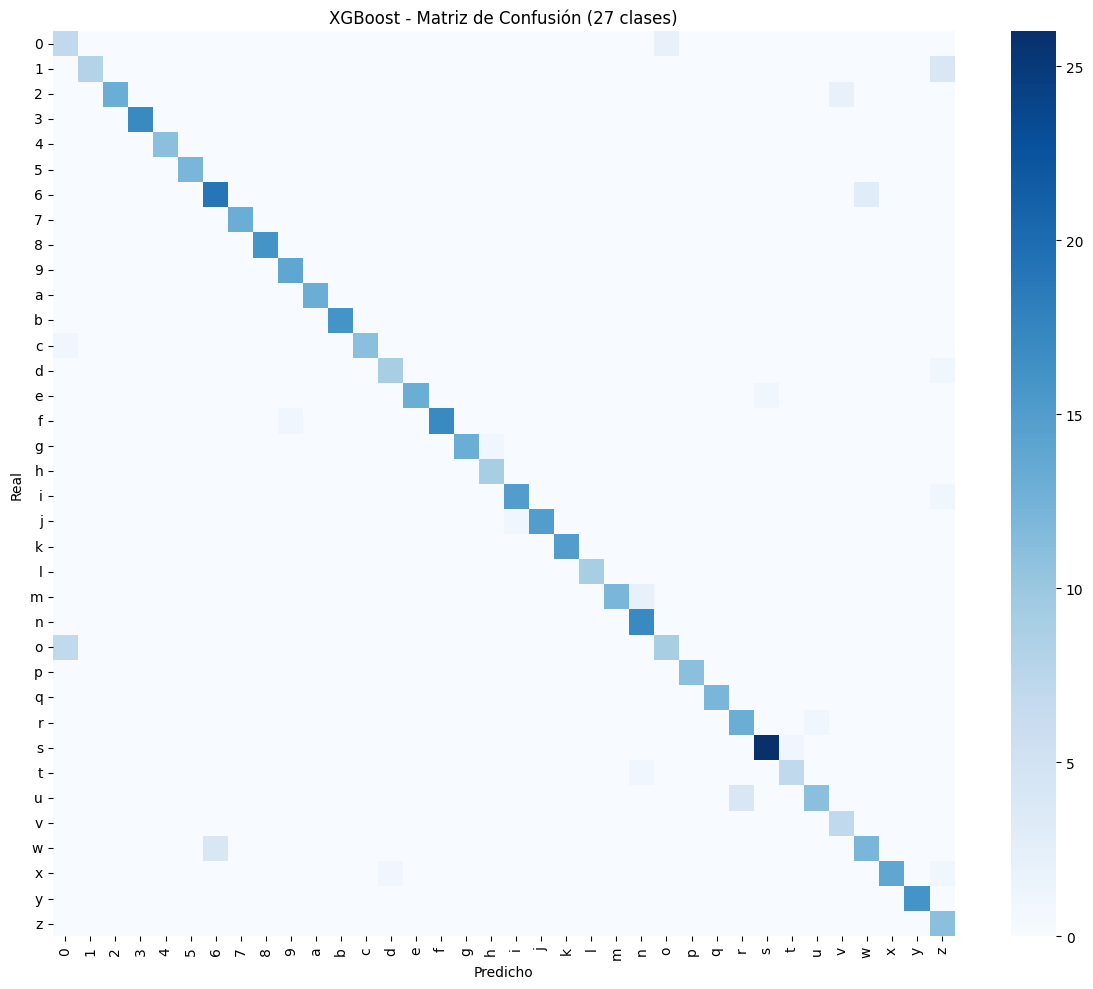

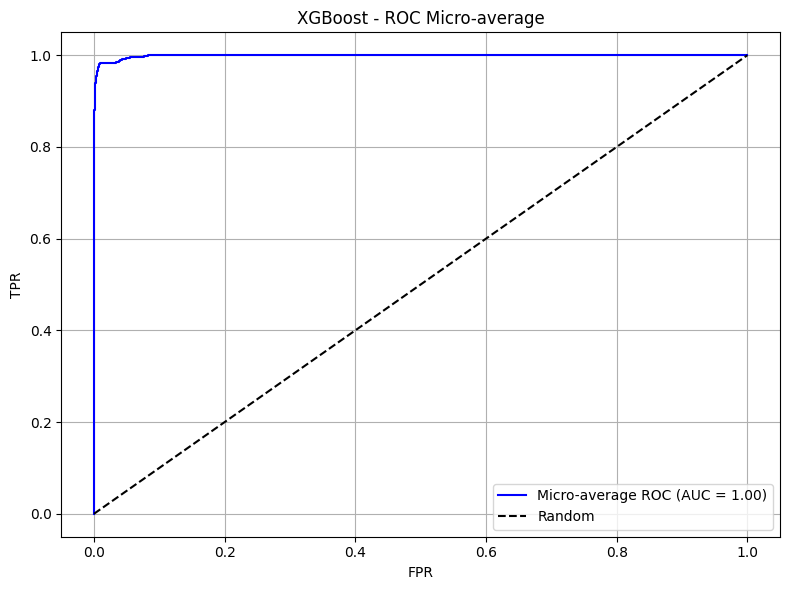

In [5]:
df = pd.read_csv(DATASET_FILE)

X = df.drop(columns=["label"])
y = df["label"]

# Codificar etiquetas
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_
n_classes = len(class_names)

# Binarizar etiquetas para ROC multiclase
y_binarized = label_binarize(y_encoded, classes=range(n_classes))

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
y_test_binarized = label_binarize(y_test, classes=range(n_classes))

# Modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=6),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)
}

best_accuracy = 0
best_model = None

# Entrenar y evaluar
for name, model in models.items():
    print(f"\n🔍 Evaluando: {name}")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probas = model.predict_proba(X_test)

    # Accuracy y reporte
    acc = accuracy_score(y_test, preds)

    if acc > best_accuracy:
        best_accuracy = acc
        best_model = name

    print(f"📊 Accuracy: {acc:.4f}")
    print(classification_report(y_test, preds, target_names=class_names))

    # Matriz de confusión
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.title(f"{name} - Matriz de Confusión (27 clases)")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()

    # ROC Curves
    fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), probas.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_micro, tpr_micro, label=f"Micro-average ROC (AUC = {roc_auc_micro:.2f})", color='blue')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.title(f"{name} - ROC Micro-average")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Predict with WebCam

In [ ]:
cap = cv2.VideoCapture(0)

if not cap.isOpened():
  raise "The camera couldn't be open"

while True:
  ret, frame = cap.read()
  if not ret:
    print("Frame Error")
    break

  rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

  results = hands.process(rgb_frame)

  if results.multi_hand_landmarks:
    for hand in results.multi_hand_landmarks:
      mp_draw.draw_landmarks(frame, hand, mp_hands.HAND_CONNECTIONS)
      h, w, _ = frame.shape
      points = []
      for lm in hand.landmark:
        x = lm.x * w
        y = lm.y * h
        points.append([x, y])

      points = np.array(points)

      points = normalize_landmarks(points)
      dist_feats = pairwise_distances(points, LANDMARKS_PAIRS)
      ang_feats = angles(points, LANDMARKS_TRIPLETS)
      area = convex_hull_area(points)
      angle = hand_orientation_angle(points)
      n_extended = count_extended_fingers(points, LANDMARKS_TIPS, LANDMARKS_PIPS)
      width, height, aspect_ratio = bounding_box_features(points)

      sample = { }

      for i, val in enumerate(dist_feats):
        sample[f"dist_{i}"] = val
      
      for i, val in enumerate(ang_feats):
        sample[f"ang_{i}"] = val

      sample["area"] = area
      sample["angle"] = angle
      sample["width"] = width
      sample["height"] = height
      sample["aspect_ratio"] = aspect_ratio
      sample["n_extended"] = n_extended
      
      sample_df = pd.DataFrame([sample])
      sample_df = sample_df.reindex(columns=X.columns, fill_value=0)
      pred = models[best_model].predict(sample_df)[0]
      pred_label = le.inverse_transform([pred])[0]
      cv2.putText(frame, f"Predicted: {pred_label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

  cv2.imshow('Webcam with Hand Landmarks', frame)

  if cv2.waitKey(1) & 0xFF == ord('q'):
    break

cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

: 